In [79]:
#import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


# CSV-Datei einlesen
df_con = pd.read_csv("constituencies_2025.csv", sep=";", on_bad_lines='skip', engine='python')
df_dem = pd.read_csv("Speaker_demographics.csv", sep=";", on_bad_lines='skip', engine='python')
df_chu = pd.read_csv("chunks.csv", sep=",", on_bad_lines='skip', engine='python')
df_spe = pd.read_csv("speeches.csv", sep=",", on_bad_lines='skip', engine='python')

# Ersten Zeilen anzeigen
df_chu.head()



,chunk_id,speech_id,debate_id,speaker_name,speaker_party,debate_title,debate_date,chunk_text,chunk_index,total_chunks,word_count,char_count,chunking_method,assigned_user,frame_label,annotation_confidence,annotation_notes,created_at,updated_at,classification_timestamp
0,chunk_220102,uk.org.publicwhip/debate/2019-03-13b.364.6,uk.org.publicwhip/debate/2019-03-13b.345.0,Chris Leslie,NaN,SPRING STATEMENT,2019-03-13,It is a fundamental mistake for the Chancellor...,0,1,96,565,semantic,NaN,economic,NaN,NaN,2025-10-13 11:05:52.85417,2025-10-13 11:05:52.85417,2025-11-02 23:26:03.503761
1,chunk_270431,uk.org.publicwhip/debate/2019-12-20a.146.6,uk.org.publicwhip/debate/2019-12-20a.146.0,Jonathan Edwards,NaN,European Union (Withdrawal Agreement) Bill,2019-12-20,The Bill contains provisions not to extend the...,0,1,40,236,semantic,NaN,powerlessness,NaN,NaN,2025-10-13 11:05:56.513287,2025-10-13 11:05:56.513287,2025-11-02 23:26:03.513426
2,chunk_231421,uk.org.publicwhip/debate/2019-04-09c.213.0,uk.org.publicwhip/debate/2019-04-09c.205.0,Alan Duncan,NaN,EXITING THE EUROPEAN UNION (SANCTIONS),2019-04-09,I think the right hon. Lady may have misunders...,0,1,215,1197,semantic,NaN,none,NaN,NaN,2025-10-13 11:05:55.054923,2025-10-13 11:05:55.054923,2025-11-02 23:26:03.516645
3,chunk_190859,uk.org.publicwhip/debate/2019-01-14b.834.2,uk.org.publicwhip/debate/2019-01-14b.823.3,Theresa May,NaN,LEAVING THE EU,2019-01-14,"Of course, the House will give its view tomorr...",0,1,109,593,semantic,NaN,economic,NaN,NaN,2025-10-13 11:05:52.342023,2025-10-13 11:05:52.342023,2025-11-02 23:26:03.520324
4,chunk_101471,uk.org.publicwhip/debate/2017-11-20b.800.1,uk.org.publicwhip/debate/2017-11-20b.758.0,Anna Soubry,NaN,DUTIES OF CUSTOMS,2017-11-20,I am not going to repeat the excellent argumen...,2,5,122,664,semantic,NaN,conflict,NaN,NaN,2025-10-13 11:05:43.267617,2025-10-13 11:05:43.267617,2025-11-02 23:26:03.523197


In [80]:
print("Rows in df_con:", len(df_con))
print("Rows in df_dem:", len(df_dem))
print("Rows in df_chu:", len(df_chu))
print("Rows in df_spe:", len(df_spe))


Rows in df_con: 650
Rows in df_dem: 1124
Rows in df_chu: 62847
Rows in df_spe: 32087


In [81]:
# Remove blank or missing twfy_id before merging
df_dem = df_dem[df_dem['twfy_id'].notna()]

# Remove blank or missing twfy_id before merging
df_spe = df_spe[df_spe['twfy_id'].notna()]

In [82]:
print("Rows in df_con:", len(df_con))
print("Rows in df_dem:", len(df_dem))
print("Rows in df_chu:", len(df_chu))
print("Rows in df_spe:", len(df_spe))

Rows in df_con: 650
Rows in df_dem: 1094
Rows in df_chu: 62847
Rows in df_spe: 31560


In [83]:
# Merge Speaker demographics and constituencies
# Select only the columns you need from df_con
const_cols = [
    'constituency',   # key to match
    'nation',
    'region',
    'area',
    'density',
    'center_lat',
    'center_lon'
]

# Merge speaker demographics with constituency info
df_dem = df_dem.merge(
    df_con[const_cols],
    left_on='Constituency',   # column in speaker dataframe
    right_on='constituency',  # column in constituencies dataframe
    how='left'                # keep all speakers, even if no constituency match
)

df_dem['twfy_id'] = (
    df_dem['twfy_id']
    .astype('Int64')      # convert float → integer (keeps NA)
    .astype(str)          # convert integer → string
)

# Quick check
df_dem.head()


,twfy_id,First name,Last name,Party,Constituency,person_id,brexit_vote,Fullname,Gender,HouseStartYear,HouseEndYear,Birthdate,constituency,nation,region,area,density,center_lat,center_lon
0,10900,Hywel,Francis,Labour,Aberafan Maesteg,uk.org.publicwhip/member/10900,NaN,Hywel Francis,M,2001.0,2015.0,06/06/1946,Aberafan Maesteg,Wales,Wales,"249,5081731","279,818489","51,60820598","-3,701807387"
1,25297,Stephen,Kinnock,Labour,Aberafan Maesteg,uk.org.publicwhip/member/25297,remain,Stephen Kinnock,M,2015.0,NaN,01/01/1970,Aberafan Maesteg,Wales,Wales,"249,5081731","279,818489","51,60820598","-3,701807387"
2,10174,Frank,Doran,Labour,Aberdeen North,uk.org.publicwhip/member/10174,NaN,Frank Doran,M,1997.0,2015.0,13/04/1949,Aberdeen North,Scotland,Scotland,"103,5741812","742,4147518","57,18740967","-2,175601003"
3,25314,Kirsty,Blackman,Scottish National Party,Aberdeen North,uk.org.publicwhip/member/25314,NaN,Kirsty Blackman,F,2015.0,NaN,20/03/1986,Aberdeen North,Scotland,Scotland,"103,5741812","742,4147518","57,18740967","-2,175601003"
4,10032,Anne,Begg,Labour,Aberdeen South,uk.org.publicwhip/member/10032,NaN,Anne Begg,F,1997.0,2015.0,06/12/1955,Aberdeen South,Scotland,Scotland,"102,0155705","750,4736739","57,12365351","-2,171649568"


In [84]:
# Merge twfy_id from speech df to chunk df
df_chu = df_chu.merge(
    df_spe[['speech_id', 'twfy_id']],
    on='speech_id',
    how='left',
)
# Quick check
df_chu.head()

,chunk_id,speech_id,debate_id,speaker_name,speaker_party,debate_title,debate_date,chunk_text,chunk_index,total_chunks,...,char_count,chunking_method,assigned_user,frame_label,annotation_confidence,annotation_notes,created_at,updated_at,classification_timestamp,twfy_id
0,chunk_220102,uk.org.publicwhip/debate/2019-03-13b.364.6,uk.org.publicwhip/debate/2019-03-13b.345.0,Chris Leslie,NaN,SPRING STATEMENT,2019-03-13,It is a fundamental mistake for the Chancellor...,0,1,...,565,semantic,NaN,economic,NaN,NaN,2025-10-13 11:05:52.85417,2025-10-13 11:05:52.85417,2025-11-02 23:26:03.503761,10354
1,chunk_270431,uk.org.publicwhip/debate/2019-12-20a.146.6,uk.org.publicwhip/debate/2019-12-20a.146.0,Jonathan Edwards,NaN,European Union (Withdrawal Agreement) Bill,2019-12-20,The Bill contains provisions not to extend the...,0,1,...,236,semantic,NaN,powerlessness,NaN,NaN,2025-10-13 11:05:56.513287,2025-10-13 11:05:56.513287,2025-11-02 23:26:03.513426,24743
2,chunk_231421,uk.org.publicwhip/debate/2019-04-09c.213.0,uk.org.publicwhip/debate/2019-04-09c.205.0,Alan Duncan,NaN,EXITING THE EUROPEAN UNION (SANCTIONS),2019-04-09,I think the right hon. Lady may have misunders...,0,1,...,1197,semantic,NaN,none,NaN,NaN,2025-10-13 11:05:55.054923,2025-10-13 11:05:55.054923,2025-11-02 23:26:03.516645,10179
3,chunk_190859,uk.org.publicwhip/debate/2019-01-14b.834.2,uk.org.publicwhip/debate/2019-01-14b.823.3,Theresa May,NaN,LEAVING THE EU,2019-01-14,"Of course, the House will give its view tomorr...",0,1,...,593,semantic,NaN,economic,NaN,NaN,2025-10-13 11:05:52.342023,2025-10-13 11:05:52.342023,2025-11-02 23:26:03.520324,10426
4,chunk_101471,uk.org.publicwhip/debate/2017-11-20b.800.1,uk.org.publicwhip/debate/2017-11-20b.758.0,Anna Soubry,NaN,DUTIES OF CUSTOMS,2017-11-20,I am not going to repeat the excellent argumen...,2,5,...,664,semantic,NaN,conflict,NaN,NaN,2025-10-13 11:05:43.267617,2025-10-13 11:05:43.267617,2025-11-02 23:26:03.523197,24772


In [85]:
# Remove blank or missing twfy_id before merging
df_chu = df_chu[df_chu['twfy_id'].notna()]
print("Rows in df_chu:", len(df_chu))

Rows in df_chu: 62115


In [86]:
# Merge Speaker demographics and chunks


# Select only the columns you need from df_dem
dem_cols = [
    "twfy_id",
    "First name",
    "Last name",
    "Party",
    'Constituency',
    "brexit_vote",
    "Gender",
    "HouseStartYear",
    "HouseEndYear",
    "Birthdate",
    'nation',
    'region',
    'area',
    'density',
    'center_lat',
    'center_lon'
]

# Merge speaker demographics with chunks
df_chu = df_chu.merge(
    df_dem[dem_cols],
    left_on='twfy_id',   # column in speaker dataframe
    right_on='twfy_id',  # column in constituencies dataframe
    how='left'                # keep all speakers, even if no constituency match
)

# Quick check
df_chu.tail()


,chunk_id,speech_id,debate_id,speaker_name,speaker_party,debate_title,debate_date,chunk_text,chunk_index,total_chunks,...,Gender,HouseStartYear,HouseEndYear,Birthdate,nation,region,area,density,center_lat,center_lon
62110,chunk_320231,uk.org.publicwhip/debate/2022-12-20a.136.0,uk.org.publicwhip/debate/2022-12-20a.135.0,Peter Aldous,NaN,Annual Fisheries Negotiations with EU and Nort...,2022-12-20,My right hon. Friend highlighted the fact that...,1,3,...,M,2010.0,2024.0,26/08/1961,England,Eastern,"988,9201565","71,33032888","52,36271946","1,238507477"
62111,chunk_320233,uk.org.publicwhip/debate/2022-12-20a.139.1,uk.org.publicwhip/debate/2022-12-20a.135.0,Peter Grant,NaN,Annual Fisheries Negotiations with EU and Nort...,2022-12-20,I am surprised to hear the Minister say that h...,0,2,...,M,2015.0,2024.0,12/10/1960,Scotland,Scotland,"173,9471272","400,8919325","56,17661961","-3,19933604"
62112,chunk_320234,uk.org.publicwhip/debate/2022-12-20a.139.1,uk.org.publicwhip/debate/2022-12-20a.135.0,Peter Grant,NaN,Annual Fisheries Negotiations with EU and Nort...,2022-12-20,"Finally, I note that one big increase in quota...",1,2,...,M,2015.0,2024.0,12/10/1960,Scotland,Scotland,"173,9471272","400,8919325","56,17661961","-3,19933604"
62113,chunk_320235,uk.org.publicwhip/debate/2022-12-20a.195.0,uk.org.publicwhip/debate/2022-12-20a.175.0,Luke Evans,NaN,Christmas Adjournment,2022-12-20,I think this may be a first. If the House will...,0,2,...,M,2019.0,NaN,10/01/1983,England,East Midlands,"290,0237753","260,954468","52,61837363","-1,427094322"
62114,chunk_320236,uk.org.publicwhip/debate/2022-12-20a.195.0,uk.org.publicwhip/debate/2022-12-20a.175.0,Luke Evans,NaN,Christmas Adjournment,2022-12-20,The UK has also been successful in implementin...,1,2,...,M,2019.0,NaN,10/01/1983,England,East Midlands,"290,0237753","260,954468","52,61837363","-1,427094322"


# Gemergtes Datenset

In [87]:
# Spalten löschen
df_final = df_chu.drop(columns=['debate_title', 'chunk_index', 'word_count', 'char_count', 'chunking_method', "assigned_user","annotation_confidence", "annotation_notes", "created_at", "updated_at", "classification_timestamp", "chunk_text", "total_chunks", "speaker_name", "speaker_party", "debate_id"])

# Kontrolle: verbleibende Spalten anzeigen
df_final


,chunk_id,speech_id,debate_date,frame_label,twfy_id,First name,Last name,Party,Constituency,brexit_vote,Gender,HouseStartYear,HouseEndYear,Birthdate,nation,region,area,density,center_lat,center_lon
0,chunk_220102,uk.org.publicwhip/debate/2019-03-13b.364.6,2019-03-13,economic,10354,Chris,Leslie,Labour/Co-operative,Nottingham East,remain,M,2010.0,2019.0,28/06/1972,England,East Midlands,"21,67565073","3475,189786","52,96518888","-1,140461389"
1,chunk_270431,uk.org.publicwhip/debate/2019-12-20a.146.6,2019-12-20,powerlessness,24743,Jonathan,Edwards,Independent,Caerfyrddin,NaN,M,2010.0,2024.0,26/05/1976,Wales,Wales,"2040,77046","35,61547044","51,9306504","-4,153879821"
2,chunk_231421,uk.org.publicwhip/debate/2019-04-09c.213.0,2019-04-09,none,10179,Alan,Duncan,Conservative,Rutland and Stamford,remain,M,1992.0,2019.0,31/03/1957,England,East Midlands,"960,0572818","73,8122624","52,68449397","-0,655618247"
3,chunk_190859,uk.org.publicwhip/debate/2019-01-14b.834.2,2019-01-14,economic,10426,Theresa,May,Conservative,Maidenhead,remain,F,1997.0,2024.0,01/10/1956,England,South East,"182,3841024","402,7927819","51,48149823","-0,743676633"
4,chunk_101471,uk.org.publicwhip/debate/2017-11-20b.800.1,2017-11-20,conflict,24772,Anna,Soubry,Conservative,Broxtowe,remain,F,2010.0,2019.0,07/12/1956,England,East Midlands,"60,72615129","1193,242095","52,97003344","-1,266782234"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62110,chunk_320231,uk.org.publicwhip/debate/2022-12-20a.136.0,2022-12-20,economic,24904,Peter,Aldous,Conservative,Waveney Valley,remain,M,2010.0,2024.0,26/08/1961,England,Eastern,"988,9201565","71,33032888","52,36271946","1,238507477"
62111,chunk_320233,uk.org.publicwhip/debate/2022-12-20a.139.1,2022-12-20,economic,25273,Peter,Grant,Scottish National Party,Glenrothes and Mid Fife,NaN,M,2015.0,2024.0,12/10/1960,Scotland,Scotland,"173,9471272","400,8919325","56,17661961","-3,19933604"
62112,chunk_320234,uk.org.publicwhip/debate/2022-12-20a.139.1,2022-12-20,conflict,25273,Peter,Grant,Scottish National Party,Glenrothes and Mid Fife,NaN,M,2015.0,2024.0,12/10/1960,Scotland,Scotland,"173,9471272","400,8919325","56,17661961","-3,19933604"
62113,chunk_320235,uk.org.publicwhip/debate/2022-12-20a.195.0,2022-12-20,economic,25805,Luke,Evans,Conservative,Hinckley and Bosworth,NaN,M,2019.0,NaN,10/01/1983,England,East Midlands,"290,0237753","260,954468","52,61837363","-1,427094322"


In [88]:
# Sicherstellen, dass Datumsformate korrekt sind
df_final['Birthdate'] = pd.to_datetime(df_final['Birthdate'], errors='coerce', dayfirst=True)
df_final['debate_date'] = pd.to_datetime(df_final['debate_date'], errors='coerce', dayfirst=True)

# 1️⃣ Alter zum Zeitpunkt der Rede (in Jahren, als ganze Zahl)
df_final['age_at_speech'] = (
    (df_final['debate_date'] - df_final['Birthdate']).dt.days / 365.25
).round(0)  # zuerst runden
df_final['age_at_speech'] = df_final['age_at_speech'].astype('Int64')  # dann in Int64 konvertieren

# 2️⃣ Jahr aus debate_date extrahieren
df_final['debate_year'] = df_final['debate_date'].dt.year

# 3️⃣ Jahre im Parlament zum Zeitpunkt der Rede (ebenfalls ganze Zahl)
df_final['years_in_house_at_speech'] = (
    df_final['debate_year'] - df_final['HouseStartYear']
)
df_final.loc[df_final['years_in_house_at_speech'] < 0, 'years_in_house_at_speech'] = np.nan
df_final['years_in_house_at_speech'] = df_final['years_in_house_at_speech'].astype('Int64')

# Kontrolle: Ausgabe prüfen
df_final


/var/folders/0c/59ptwnc93nscv24nvlwjhn2h0000gn/T/ipykernel_84934/1550901090.py:3: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



,chunk_id,speech_id,debate_date,frame_label,twfy_id,First name,Last name,Party,Constituency,brexit_vote,...,Birthdate,nation,region,area,density,center_lat,center_lon,age_at_speech,debate_year,years_in_house_at_speech
0,chunk_220102,uk.org.publicwhip/debate/2019-03-13b.364.6,2019-03-13,economic,10354,Chris,Leslie,Labour/Co-operative,Nottingham East,remain,...,1972-06-28,England,East Midlands,"21,67565073","3475,189786","52,96518888","-1,140461389",47,2019,9
1,chunk_270431,uk.org.publicwhip/debate/2019-12-20a.146.6,2019-12-20,powerlessness,24743,Jonathan,Edwards,Independent,Caerfyrddin,NaN,...,1976-05-26,Wales,Wales,"2040,77046","35,61547044","51,9306504","-4,153879821",44,2019,9
2,chunk_231421,uk.org.publicwhip/debate/2019-04-09c.213.0,2019-04-09,none,10179,Alan,Duncan,Conservative,Rutland and Stamford,remain,...,1957-03-31,England,East Midlands,"960,0572818","73,8122624","52,68449397","-0,655618247",62,2019,27
3,chunk_190859,uk.org.publicwhip/debate/2019-01-14b.834.2,2019-01-14,economic,10426,Theresa,May,Conservative,Maidenhead,remain,...,1956-10-01,England,South East,"182,3841024","402,7927819","51,48149823","-0,743676633",62,2019,22
4,chunk_101471,uk.org.publicwhip/debate/2017-11-20b.800.1,2017-11-20,conflict,24772,Anna,Soubry,Conservative,Broxtowe,remain,...,1956-12-07,England,East Midlands,"60,72615129","1193,242095","52,97003344","-1,266782234",61,2017,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62110,chunk_320231,uk.org.publicwhip/debate/2022-12-20a.136.0,2022-12-20,economic,24904,Peter,Aldous,Conservative,Waveney Valley,remain,...,1961-08-26,England,Eastern,"988,9201565","71,33032888","52,36271946","1,238507477",61,2022,12
62111,chunk_320233,uk.org.publicwhip/debate/2022-12-20a.139.1,2022-12-20,economic,25273,Peter,Grant,Scottish National Party,Glenrothes and Mid Fife,NaN,...,1960-10-12,Scotland,Scotland,"173,9471272","400,8919325","56,17661961","-3,19933604",62,2022,7
62112,chunk_320234,uk.org.publicwhip/debate/2022-12-20a.139.1,2022-12-20,conflict,25273,Peter,Grant,Scottish National Party,Glenrothes and Mid Fife,NaN,...,1960-10-12,Scotland,Scotland,"173,9471272","400,8919325","56,17661961","-3,19933604",62,2022,7
62113,chunk_320235,uk.org.publicwhip/debate/2022-12-20a.195.0,2022-12-20,economic,25805,Luke,Evans,Conservative,Hinckley and Bosworth,NaN,...,1983-01-10,England,East Midlands,"290,0237753","260,954468","52,61837363","-1,427094322",40,2022,3


# Geographical Analysis

In [89]:
# Work on a copy
df_geo = df_final.copy()

# --- 1. Total corpus size ---
total_chunks = len(df_geo)

# --- 2. Keep only chunks with valid nation information ---
df_geo_valid = df_geo.dropna(subset=['nation'])
total_valid = len(df_geo_valid)
coverage = total_valid / total_chunks * 100

print(f"Total chunks in corpus: {total_chunks:,}")
print(f"Chunks with valid nation info: {total_valid:,} ({coverage:.1f}%)")

# --- 3. Counts & percentages per nation ---
nation_counts = df_geo_valid['nation'].value_counts().sort_index()
nation_pct = (nation_counts / total_valid * 100)

nation_table = pd.DataFrame({
    'chunks': nation_counts,
    'pct_of_geo_corpus': nation_pct.round(2)
})
print("\nChunks per nation:")
display(nation_table)

# Convenience variables for the four main nations
eng_count = nation_counts.get('England', 0)
sco_count = nation_counts.get('Scotland', 0)
wal_count = nation_counts.get('Wales', 0)
ni_count  = nation_counts.get('Northern Ireland', 0)

eng_pct = nation_pct.get('England', 0.0)
sco_pct = nation_pct.get('Scotland', 0.0)
wal_pct = nation_pct.get('Wales', 0.0)
ni_pct  = nation_pct.get('Northern Ireland', 0.0)

# If you want to know how many chunks DON'T have a nation label:
other_chunks = total_chunks - total_valid
other_pct = other_chunks / total_chunks * 100
print(f"\nChunks without nation info: {other_chunks:,} ({other_pct:.1f}%)")


Total chunks in corpus: 62,115
Chunks with valid nation info: 60,907 (98.1%)

Chunks per nation:


,chunks,pct_of_geo_corpus
nation,,
England,44886,73.70
Northern Ireland,1828,3.00
Scotland,10596,17.40
Wales,3597,5.91



Chunks without nation info: 1,208 (1.9%)


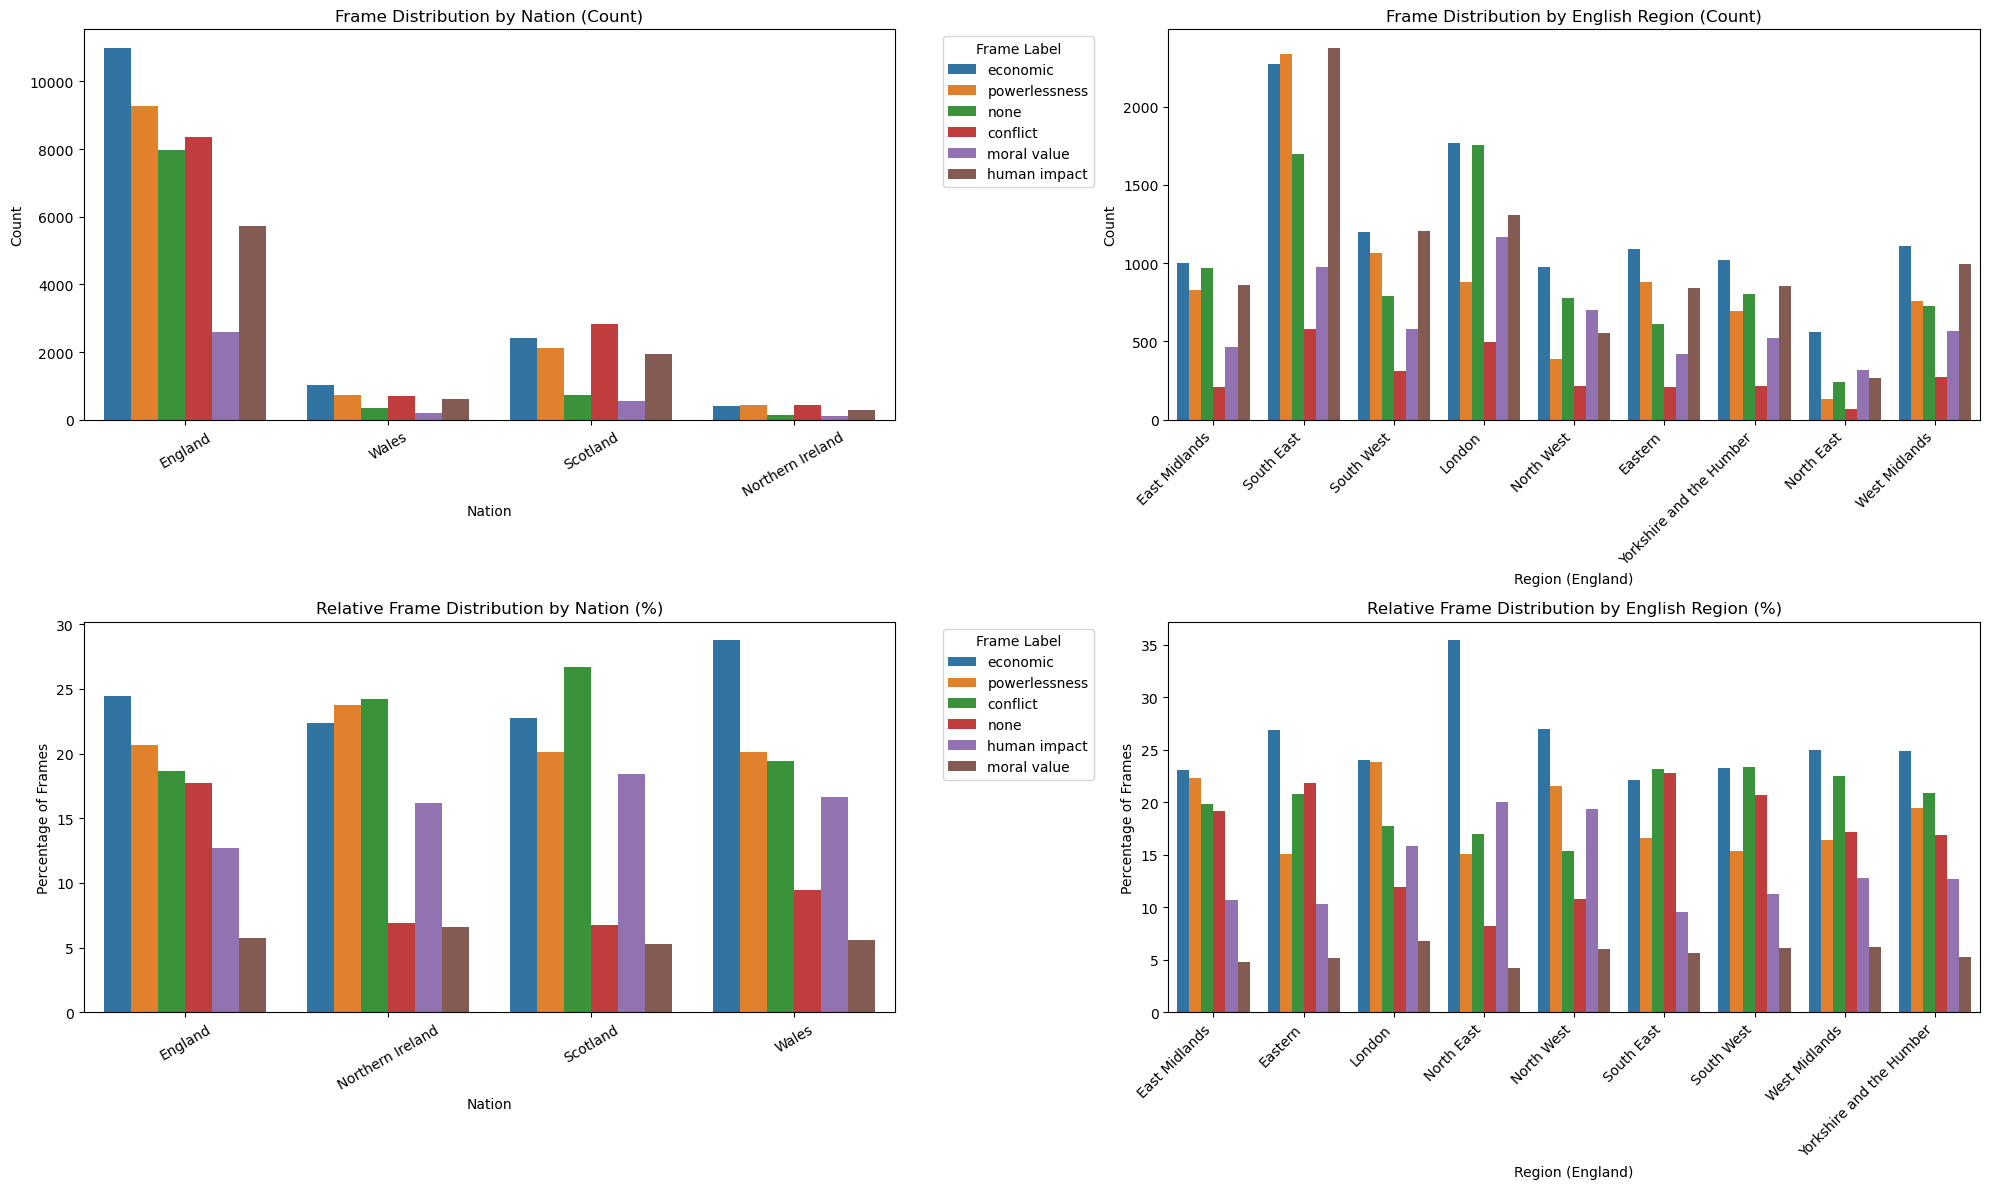

In [90]:
# 1️⃣ England-Subset (basierend auf df_geo_valid)
df_england = df_geo_valid[df_geo_valid['nation'] == 'England'].copy()

# 2️⃣ Prozentuale Verteilung pro Nation (nur gültige Nationen)
nation_pct = (
    df_geo_valid
    .groupby('nation')['frame_label']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
)

# 3️⃣ Prozentuale Verteilung pro Region (nur England)
region_pct = (
    df_england
    .groupby('region')['frame_label']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percentage')
    .reset_index()
)

# 4️⃣ Plots: 2x2-Layout
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# --- (1,1) Counts nach Nation ---
sns.countplot(
    data=df_geo_valid,
    x='nation',
    hue='frame_label',
    ax=axes[0, 0]
)
axes[0, 0].set_title('Frame Distribution by Nation (Count)')
axes[0, 0].set_xlabel('Nation')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=30)
axes[0, 0].legend(title='Frame Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- (1,2) Counts nach Region in England ---
sns.countplot(
    data=df_england,
    x='region',
    hue='frame_label',
    ax=axes[0, 1]
)
axes[0, 1].set_title('Frame Distribution by English Region (Count)')
axes[0, 1].set_xlabel('Region (England)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].legend([], [], frameon=False)  # doppelte Legende ausblenden

# --- (2,1) Prozentuale Verteilung nach Nation ---
sns.barplot(
    data=nation_pct,
    x='nation',
    y='percentage',
    hue='frame_label',
    ax=axes[1, 0]
)
axes[1, 0].set_title('Relative Frame Distribution by Nation (%)')
axes[1, 0].set_xlabel('Nation')
axes[1, 0].set_ylabel('Percentage of Frames')
axes[1, 0].tick_params(axis='x', rotation=30)
axes[1, 0].legend(title='Frame Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- (2,2) Prozentuale Verteilung nach Region (England) ---
sns.barplot(
    data=region_pct,
    x='region',
    y='percentage',
    hue='frame_label',
    ax=axes[1, 1]
)
axes[1, 1].set_title('Relative Frame Distribution by English Region (%)')
axes[1, 1].set_xlabel('Region (England)')
axes[1, 1].set_ylabel('Percentage of Frames')
axes[1, 1].tick_params(axis='x')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()


In [91]:
# -----------------------------
# CONFIG
# -----------------------------
ALPHA = 0.05          # significance threshold
EXCLUDE_NONE = True   # set False if you want to include frame 'none'

# -----------------------------
# PREP DATA
# -----------------------------
# Start from geo-based dataframe (only rows with valid nation)
df_ana = df_geo_valid.copy()

# Optional: exclude "none" frames
if EXCLUDE_NONE:
    df_ana = df_ana[df_ana['frame_label'].str.lower() != 'none']

# Keep only rows with valid frame label
df_ana = df_ana.dropna(subset=['frame_label'])

# List of nations in the data
nations = df_ana['nation'].unique()

# -----------------------------
# HELPER: Cramér's V
# -----------------------------
def cramers_v(chi2, n, r, c):
    # r = number of rows, c = number of columns in contingency table
    denom = n * (min(r - 1, c - 1))
    return np.sqrt(chi2 / denom) if denom > 0 else np.nan

# -----------------------------
# CHI-SQUARE: each nation vs all others
# -----------------------------
results = []

for nat in nations:
    sub = df_ana.copy()
    
    # Binary grouping: this nation vs "Other nations"
    sub['group'] = np.where(sub['nation'] == nat, nat, 'Other')
    
    # Contingency table: rows = group (nat vs Other), cols = frames
    contingency = pd.crosstab(sub['group'], sub['frame_label'])
    
    # Run chi-square
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.values.sum()
    r, c = contingency.shape
    V = cramers_v(chi2, n, r, c)
    
    results.append({
        'Nation': nat,
        'Chi2': chi2,
        'P_value': p,
        "Cramers_V": V,
        'df': dof,
        'N': n,
        'significant': p < ALPHA
    })

# -----------------------------
# RESULTS TABLE
# -----------------------------
nation_results = (
    pd.DataFrame(results)
    .sort_values('Chi2', ascending=False)
    .reset_index(drop=True)
)

display(
    nation_results.style.format({
        'Chi2': '{:.2f}',
        'P_value': '{:.3g}',
        'Cramers_V': '{:.3f}',
        'N': '{:,.0f}',
        'df': '{:.0f}'
    })
)

# Optional: also print plain text
print(nation_results[['Nation', 'Chi2', 'P_value', 'Cramers_V', 'df', 'N', 'significant']])


,Nation,Chi2,P_value,Cramers_V,df,N,significant
0,Scotland,331.73,1.54e-70,0.080,4,"51,754",True
1,England,273.44,5.8e-58,0.073,4,"51,754",True
2,Wales,33.83,8.07e-07,0.026,4,"51,754",True
3,Northern Ireland,18.96,0.0008,0.019,4,"51,754",True


             Nation        Chi2       P_value  Cramers_V  df      N  \
0          Scotland  331.729227  1.542687e-70   0.080061   4  51754   
1           England  273.435069  5.798536e-58   0.072687   4  51754   
2             Wales   33.831018  8.070807e-07   0.025567   4  51754   
3  Northern Ireland   18.959531  8.004638e-04   0.019140   4  51754   

   significant  
0         True  
1         True  
2         True  
3         True  


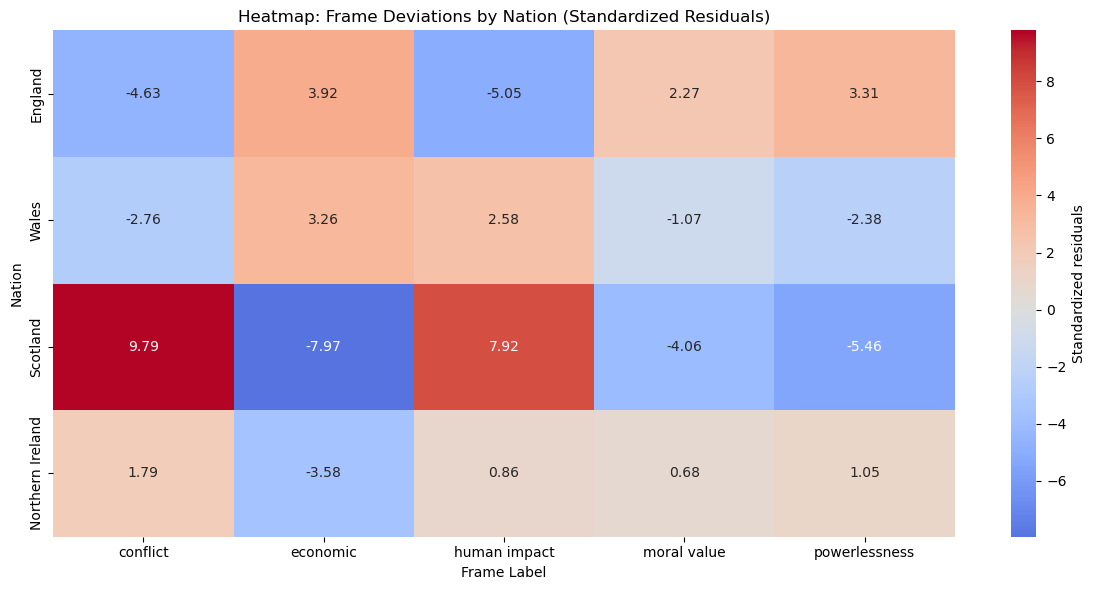

In [92]:
# ---------------------------------------------
# HEATMAP OF STANDARDIZED RESIDUALS:
# Nation × Frame deviations from expected
# ---------------------------------------------

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Optional: exclude 'none'
df_resid = df_geo_valid.copy()
df_resid = df_resid[df_resid['frame_label'].str.lower() != 'none']

# contingency table
cont_table = pd.crosstab(df_resid['nation'], df_resid['frame_label'])

# Chi-square to get expected counts
chi2, p, dof, expected = chi2_contingency(cont_table)

# standardised residuals = (observed - expected) / sqrt(expected)
std_residuals = (cont_table - expected) / np.sqrt(expected)

# Convert to dataframe for plotting
resid_df = pd.DataFrame(
    std_residuals,
    index=cont_table.index,
    columns=cont_table.columns
)

# optional ordering
nation_order = ["England", "Wales", "Scotland", "Northern Ireland"]
frame_order = sorted(resid_df.columns)

resid_df = resid_df.reindex(index=nation_order, columns=frame_order)

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.heatmap(
    resid_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Standardized residuals'}
)

plt.title("Heatmap: Frame Deviations by Nation (Standardized Residuals)")
plt.xlabel("Frame Label")
plt.ylabel("Nation")
plt.tight_layout()
plt.show()
